In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# IMPORT DATA 

In [2]:
df = pd.read_csv('featuresdataset.csv', parse_dates=['Date'])
df

,Date,Temperature,Fuel_Price
0,2010-02-05,42.31,2.572
1,2010-02-12,38.51,2.548
2,2010-02-19,39.93,2.514
3,2010-02-26,46.63,2.561
4,2010-03-05,46.50,2.625
...,...,...,...
8185,2013-06-28,76.05,3.639
8186,2013-07-05,77.50,3.614
8187,2013-07-12,79.37,3.614
8188,2013-07-19,82.84,3.737


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)


In [4]:
df

,Temperature,Fuel_Price
Date,,
2010-02-05,42.31,2.572
2010-02-12,38.51,2.548
2010-02-19,39.93,2.514
2010-02-26,46.63,2.561
2010-03-05,46.50,2.625
...,...,...
2013-06-28,76.05,3.639
2013-07-05,77.50,3.614
2013-07-12,79.37,3.614


In [5]:
print(df.dtypes)

Temperature    float64
Fuel_Price     float64
dtype: object


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8190 entries, 2010-02-05 to 2013-07-26
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  8190 non-null   float64
 1   Fuel_Price   8190 non-null   float64
dtypes: float64(2)
memory usage: 192.0 KB


In [7]:
df.isnull().sum()

Temperature    0
Fuel_Price     0
dtype: int64

# PREPROCESSING

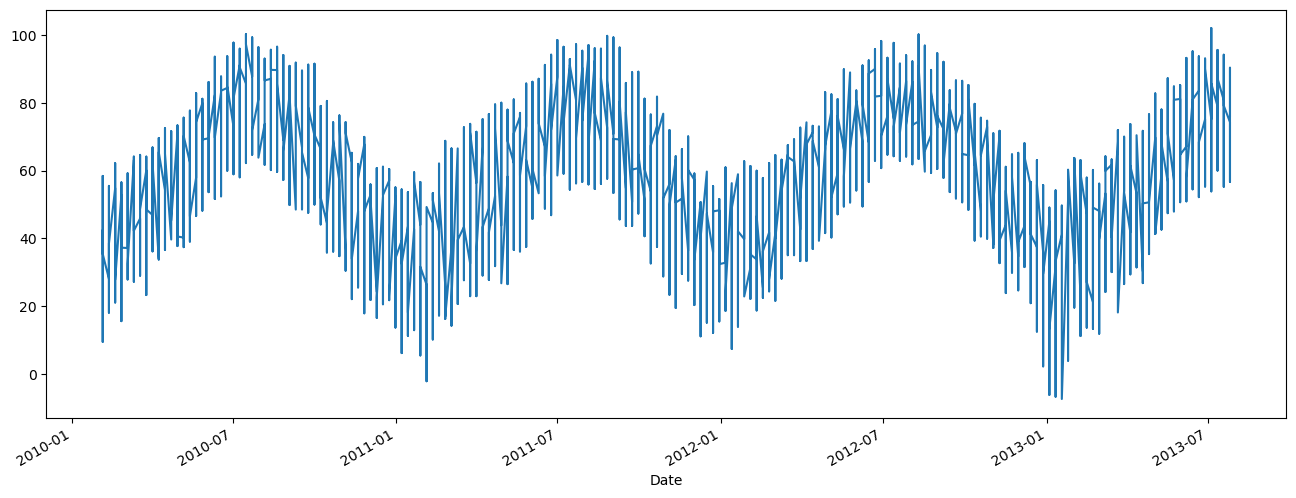

In [8]:
plt.figure(figsize=(16,6))
df['Temperature'].plot()
plt.show()

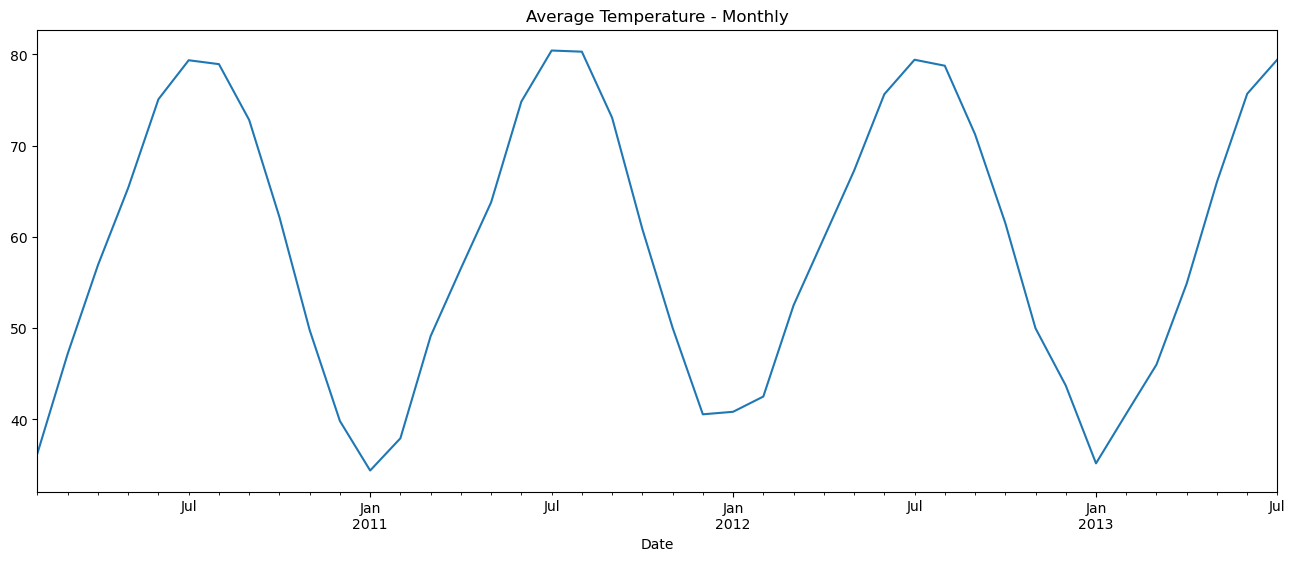

In [9]:
df_month = df.resample('M').mean() # resampling as monthly
plt.figure(figsize=(16,6))
df_month['Temperature'].plot()
plt.title('Average Temperature - Monthly')
plt.show()

# CEK STATIONARITAS DATA

In [10]:
adf_result = stattools.adfuller(df_month['Temperature'], autolag='AIC')
adf_result

# Menentukan apakah data stasioner atau tidak
if adf_result[1] <= 0.05:
    print("P-value <= 0.05. Data bersifat stasioner.")
else:
    print("P-value > 0.05. Data tidak bersifat stasioner.")

P-value > 0.05. Data tidak bersifat stasioner.


# HANDLING STATIONARITAS WITH DIFFERENCING

In [11]:
# Lakukan differencing pada data bulanan
df_month_diff = df_month['Temperature'].diff().dropna()

# Uji stasioneritas setelah differencing
adf_result_diff = stattools.adfuller(df_month_diff, autolag='AIC')

# Menampilkan hasil uji setelah differencing
print('ADF Statistic (After Differencing):', adf_result_diff[0])
print('p-value (After Differencing):', adf_result_diff[1])
print('Critical Values (After Differencing):', adf_result_diff[4])

# Menentukan apakah data stasioner atau tidak
if adf_result_diff[1] <= 0.05:
    print("P-value <= 0.05. Data bersifat stasioner.")
else:
    print("P-value > 0.05. Data tidak bersifat stasioner.")

ADF Statistic (After Differencing): -5.987429769097833
p-value (After Differencing): 1.7783999848144416e-07
Critical Values (After Differencing): {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}
P-value <= 0.05. Data bersifat stasioner.


# PLOT ACF DAN PACF

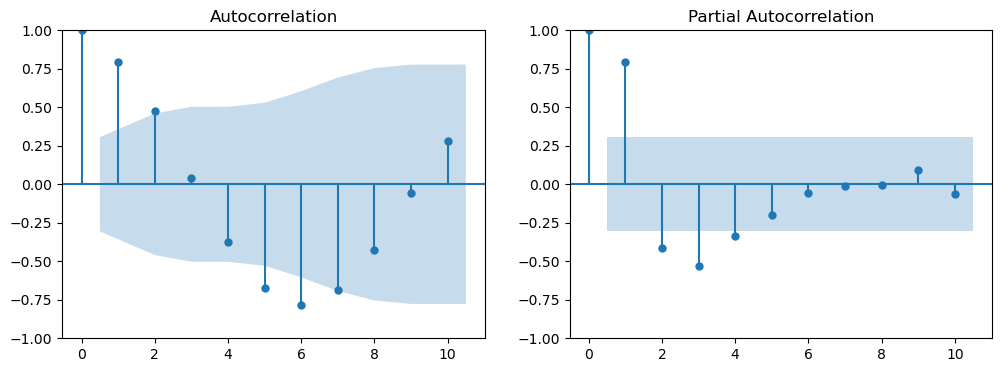

In [12]:
# Plot ACF dan PACF dari data differencing
def plot_acf_pacf(data, max_lags=30):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(data, lags=max_lags, ax=ax1)
    plot_pacf(data, lags=max_lags, ax=ax2)
    plt.show()

# Tampilkan plot ACF dan PACF untuk df_month_diff
plot_acf_pacf(df_month_diff, max_lags=10)  # Mengurangi jumlah lag menjadi 10 atau sesuai dengan setengah dari ukuran sampel data

# PEMILIHAN MODEL

# train and split data

In [13]:
# Pembagian data menjadi set pelatihan dan set pengujian
train_size = int(len(df_month_diff) * 0.8)  # Menggunakan 80% data untuk pelatihan
train, test = df_month_diff[0:train_size], df_month_diff[train_size:]

# Menampilkan panjang set pelatihan dan set pengujian
print(f'Jumlah data pelatihan: {len(train)}')
print(f'Jumlah data pengujian: {len(test)}')


Jumlah data pelatihan: 32
Jumlah data pengujian: 9


# 1. SARIMA

Mean Squared Error (MSE): 9.445318304703662
Mean Absolute Error (MAE): 2.626890528213549


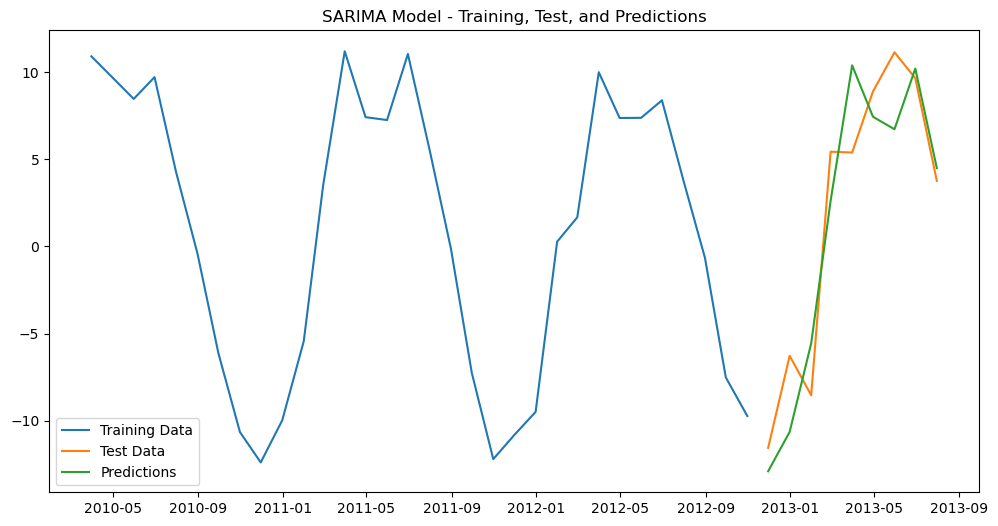

In [16]:
# Melatih model SARIMA
order = (1, 1, 1)  # Sesuaikan nilai p, d, dan q sesuai hasil analisis ACF dan PACF
seasonal_order = (1, 1, 2, 12)  # Sesuaikan nilai P, D, Q, dan m sesuai hasil analisis seasonal ACF dan PACF
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_model = model.fit()

# Melakukan prediksi pada set pengujian
predictions = fit_model.get_forecast(steps=len(test))

# Menghitung dan menampilkan metrik evaluasi
mse = mean_squared_error(test, predictions.predicted_mean)
mae = mean_absolute_error(test, predictions.predicted_mean)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions.predicted_mean, label='Predictions')
plt.title('SARIMA Model - Training, Test, and Predictions')
plt.legend()
plt.show()


# MOVING AVERAGE

Mean Squared Error (MSE) for MA(6) Forecast: 38.47678653949394
Mean Absolute Error (MAE) for MA(6) Forecast: 5.178204459144927


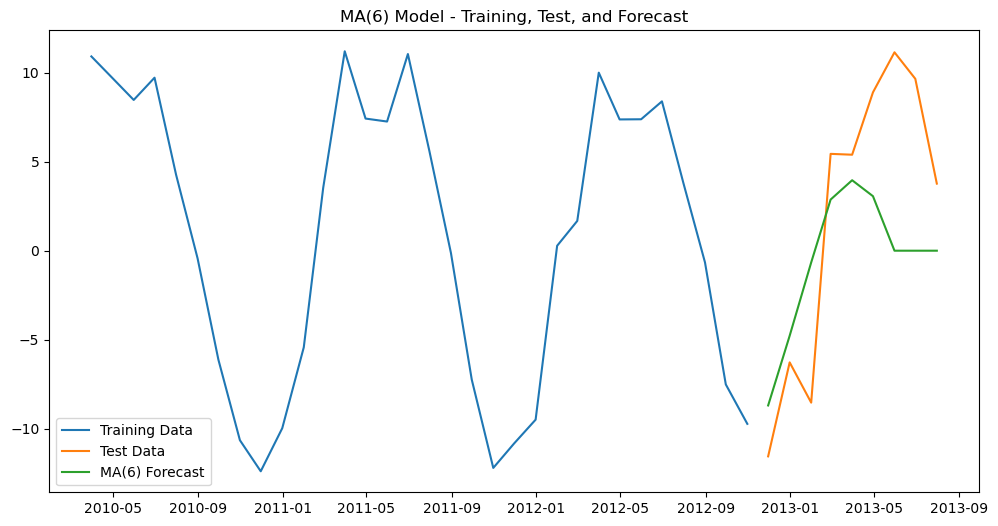

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the order for the MA(6) model
order = (0, 0, 6)

# Fit the SARIMA model with the specified order
model_ma3 = SARIMAX(train, order=order)
fit_model_ma3 = model_ma3.fit()

# Generate forecast for the test set
forecast_ma3 = fit_model_ma3.get_forecast(steps=len(test))

# Evaluate the forecast using mean squared error and mean absolute error
mse_ma3 = mean_squared_error(test, forecast_ma3.predicted_mean)
mae_ma3 = mean_absolute_error(test, forecast_ma3.predicted_mean)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE) for MA(6) Forecast: {mse_ma3}')
print(f'Mean Absolute Error (MAE) for MA(6) Forecast: {mae_ma3}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_ma3.predicted_mean, label='MA(6) Forecast')
plt.title('MA(6) Model - Training, Test, and Forecast')
plt.legend()
plt.show()


# SARIMAX

Mean Squared Error (MSE) for SARIMAX: 8.659653268532749
Mean Absolute Error (MAE) for SARIMAX: 2.3582517750363774


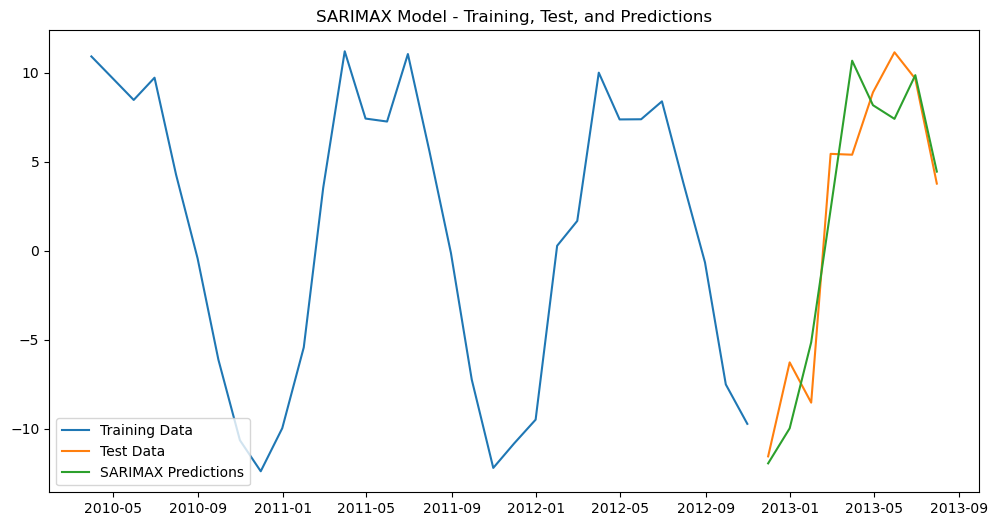

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lakukan differencing pada data bulanan
df_month_diff_temp = df_month['Temperature'].diff().dropna()
df_month_diff_fuel = df_month['Fuel_Price'].diff().dropna()

# Pemisahan data eksogen dan endogen
exog_vars = df_month_diff_fuel  # Ganti dengan nama variabel eksogen yang sesuai
endog_var = df_month_diff_temp

# Pembagian data menjadi set pelatihan dan set pengujian
train_size = int(len(endog_var) * 0.8)
train, test = endog_var[0:train_size], endog_var[train_size:]

# Menggabungkan data endogen dan eksogen untuk set pelatihan
train_data = pd.DataFrame({'endog': train.values, 'exog': exog_vars[:len(train)]})

# Melatih model SARIMAX
order = (1, 1, 1)  
seasonal_order = (1, 1, 2, 12)  
model_sarimax = SARIMAX(endog=train_data['endog'], exog=train_data['exog'], order=order, seasonal_order=seasonal_order)
fit_model_sarimax = model_sarimax.fit()

# Menggabungkan data endogen dan eksogen untuk set pengujian
test_data = pd.DataFrame({'endog': test.values, 'exog': exog_vars[len(train):]})

# Melakukan prediksi pada set pengujian
predictions_sarimax = fit_model_sarimax.get_forecast(steps=len(test_data), exog=test_data['exog'])

# Menghitung dan menampilkan metrik evaluasi
mse_sarimax = mean_squared_error(test_data['endog'], predictions_sarimax.predicted_mean)
mae_sarimax = mean_absolute_error(test_data['endog'], predictions_sarimax.predicted_mean)
print(f'Mean Squared Error (MSE) for SARIMAX: {mse_sarimax}')
print(f'Mean Absolute Error (MAE) for SARIMAX: {mae_sarimax}')

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train_data['endog'], label='Training Data')
plt.plot(test_data['endog'], label='Test Data')
plt.plot(predictions_sarimax.predicted_mean, label='SARIMAX Predictions')
plt.title('SARIMAX Model - Training, Test, and Predictions')
plt.legend()
plt.show()


# PEMODELAN JANGKA PENDEK(SHORT TERM) 
# DAN JANGKA PANJANG(LONG TERM) 
# BERDASARKAN WAKTU PREDIKSI KEDEPAN

In [19]:
# Prediksi Jangka Pendek (3 Step) untuk Model SARIMA
forecast_short = fit_model.get_forecast(steps=3)

# Prediksi Jangka Panjang (6 Step) untuk Model SARIMA
forecast_long = fit_model.get_forecast(steps=6)

# Menampilkan hasil prediksi
print("SARIMA Short-Term Forecast:")
print(forecast_short.predicted_mean)

print("\nSARIMA Long-Term Forecast:")
print(forecast_long.predicted_mean)


SARIMA Short-Term Forecast:
2012-11-30   -12.890451
2012-12-31   -10.630067
2013-01-31    -5.552382
Freq: M, Name: predicted_mean, dtype: float64

SARIMA Long-Term Forecast:
2012-11-30   -12.890451
2012-12-31   -10.630067
2013-01-31    -5.552382
2013-02-28     2.625290
2013-03-31    10.388095
2013-04-30     7.439503
Freq: M, Name: predicted_mean, dtype: float64


In [20]:
# Prediksi Jangka Pendek (3 Step) untuk Model MA(6)
forecast_ma3_short = fit_model_ma3.get_forecast(steps=3)

# Prediksi Jangka Panjang (6 Step) untuk Model MA(6)
forecast_ma3_long = fit_model_ma3.get_forecast(steps=6)

# Menampilkan hasil prediksi
print("MA(6) Short-Term Forecast:")
print(forecast_ma3_short.predicted_mean)

print("\nMA(6) Long-Term Forecast:")
print(forecast_ma3_long.predicted_mean)


MA(6) Short-Term Forecast:
2012-11-30   -8.688035
2012-12-31   -4.773976
2013-01-31   -0.660622
Freq: M, Name: predicted_mean, dtype: float64

MA(6) Long-Term Forecast:
2012-11-30   -8.688035
2012-12-31   -4.773976
2013-01-31   -0.660622
2013-02-28    2.870906
2013-03-31    3.955713
2013-04-30    3.060074
Freq: M, Name: predicted_mean, dtype: float64


In [21]:
# Prediksi Jangka Pendek (3 Step) untuk Model SARIMAX
predictions_sarimax_short = fit_model_sarimax.get_forecast(steps=3, exog=test_data['exog'][:3])

# Prediksi Jangka Panjang (6 Step) untuk Model SARIMAX
predictions_sarimax_long = fit_model_sarimax.get_forecast(steps=6, exog=test_data['exog'][:6])

# Menampilkan hasil prediksi
print("SARIMAX Short-Term Forecast:")
print(predictions_sarimax_short.predicted_mean)

print("\nSARIMAX Long-Term Forecast:")
print(predictions_sarimax_long.predicted_mean)


SARIMAX Short-Term Forecast:
2012-11-30   -11.938797
2012-12-31    -9.973154
2013-01-31    -5.143302
Freq: M, Name: predicted_mean, dtype: float64

SARIMAX Long-Term Forecast:
2012-11-30   -11.938797
2012-12-31    -9.973154
2013-01-31    -5.143302
2013-02-28     2.310366
2013-03-31    10.665773
2013-04-30     8.168312
Freq: M, Name: predicted_mean, dtype: float64


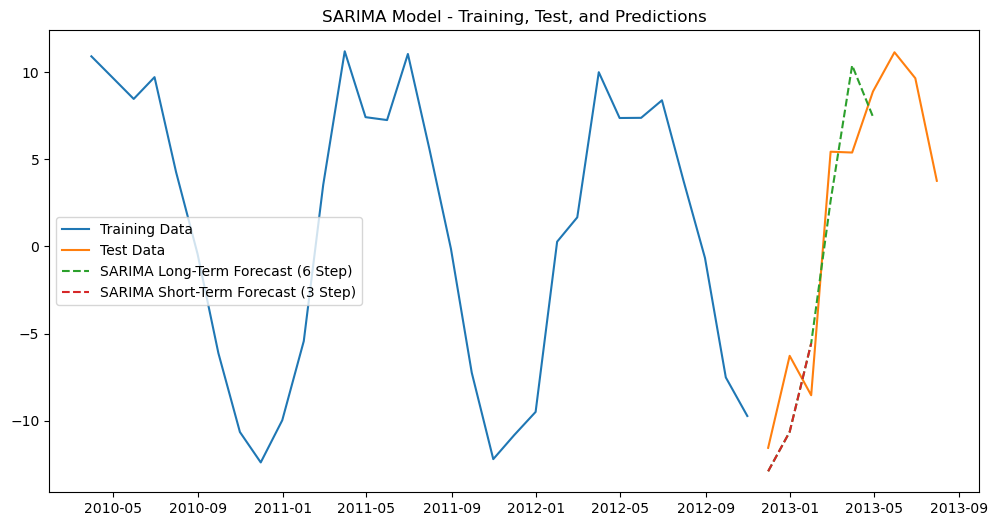

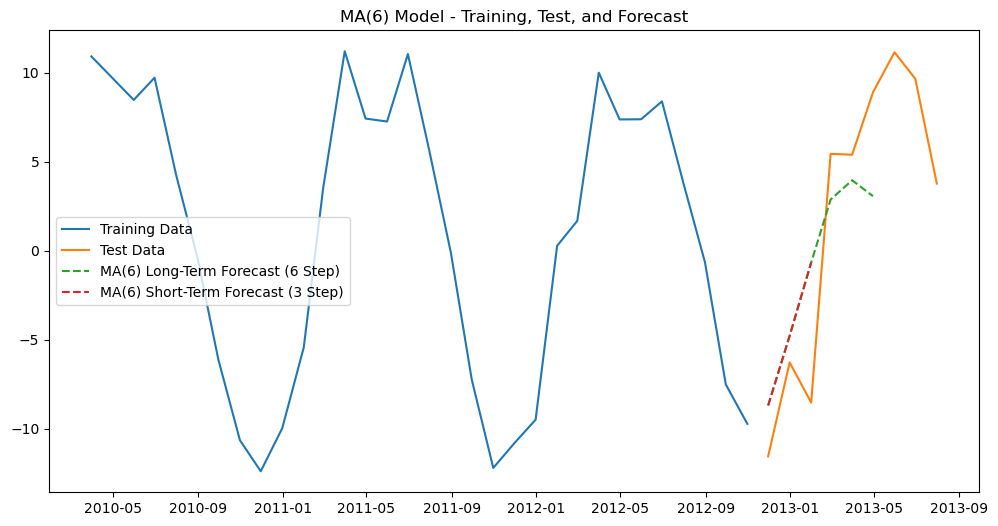

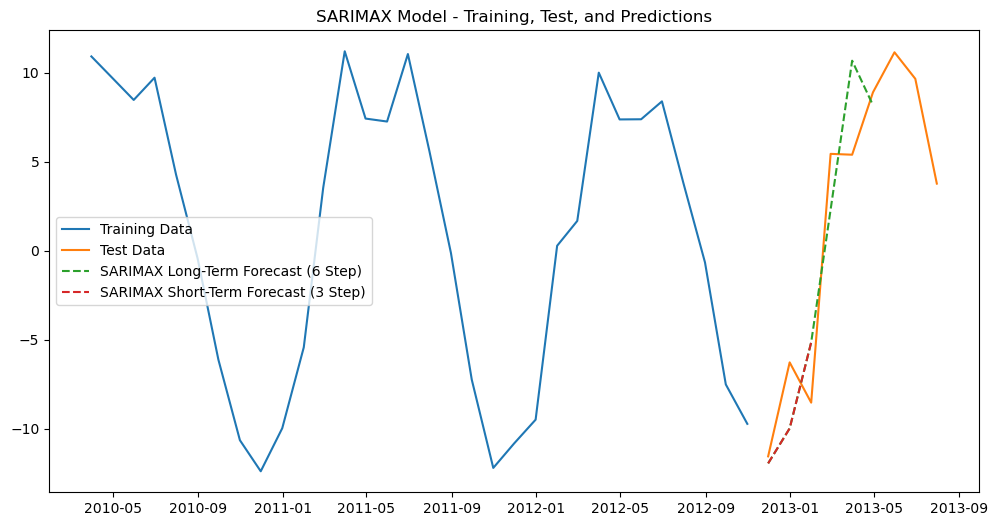

In [22]:
# Visualisasi hasil prediksi jangka pendek (3 Step) dan jangka panjang (6 Step) untuk Model SARIMA
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_long.predicted_mean, label='SARIMA Long-Term Forecast (6 Step)', linestyle='dashed')
plt.plot(forecast_short.predicted_mean, label='SARIMA Short-Term Forecast (3 Step)', linestyle='dashed')
plt.title('SARIMA Model - Training, Test, and Predictions')
plt.legend()
plt.show()

# Visualisasi hasil prediksi jangka pendek (3 Step) dan jangka panjang (6 Step) untuk Model MA(6)
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_ma3_long.predicted_mean, label='MA(6) Long-Term Forecast (6 Step)', linestyle='dashed')
plt.plot(forecast_ma3_short.predicted_mean, label='MA(6) Short-Term Forecast (3 Step)', linestyle='dashed')
plt.title('MA(6) Model - Training, Test, and Forecast')
plt.legend()
plt.show()


# Visualisasi hasil prediksi jangka pendek (3 Step) dan jangka panjang (6 Step) untuk Model SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(train_data['endog'], label='Training Data')
plt.plot(test_data['endog'], label='Test Data')
plt.plot(predictions_sarimax_long.predicted_mean, label='SARIMAX Long-Term Forecast (6 Step)', linestyle='dashed')
plt.plot(predictions_sarimax_short.predicted_mean, label='SARIMAX Short-Term Forecast (3 Step)', linestyle='dashed')
plt.title('SARIMAX Model - Training, Test, and Predictions')
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# SARIMA Short-Term Forecast
mse_sarima_short = mean_squared_error(test_data['endog'][:3], forecast_short.predicted_mean)
mae_sarima_short = mean_absolute_error(test_data['endog'][:3], forecast_short.predicted_mean)
print("SARIMA Short-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_sarima_short}')
print(f'Mean Absolute Error (MAE): {mae_sarima_short}')

# SARIMA Long-Term Forecast
mse_sarima_long = mean_squared_error(test_data['endog'][:6], forecast_long.predicted_mean)
mae_sarima_long = mean_absolute_error(test_data['endog'][:6], forecast_long.predicted_mean)
print("\nSARIMA Long-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_sarima_long}')
print(f'Mean Absolute Error (MAE): {mae_sarima_long}')

# MA(6) Short-Term Forecast
mse_ma3_short = mean_squared_error(test_data['endog'][:3], forecast_ma3_short.predicted_mean)
mae_ma3_short = mean_absolute_error(test_data['endog'][:3], forecast_ma3_short.predicted_mean)
print("\nMA(6) Short-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_ma3_short}')
print(f'Mean Absolute Error (MAE): {mae_ma3_short}')

# MA(6) Long-Term Forecast
mse_ma3_long = mean_squared_error(test_data['endog'][:6], forecast_ma3_long.predicted_mean)
mae_ma3_long = mean_absolute_error(test_data['endog'][:6], forecast_ma3_long.predicted_mean)
print("\nMA(6) Long-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_ma3_long}')
print(f'Mean Absolute Error (MAE): {mae_ma3_long}')

# SARIMAX Short-Term Forecast
mse_sarimax_short = mean_squared_error(test_data['endog'][:3], predictions_sarimax_short.predicted_mean)
mae_sarimax_short = mean_absolute_error(test_data['endog'][:3], predictions_sarimax_short.predicted_mean)
print("\nSARIMAX Short-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_sarimax_short}')
print(f'Mean Absolute Error (MAE): {mae_sarimax_short}')

# SARIMAX Long-Term Forecast
mse_sarimax_long = mean_squared_error(test_data['endog'][:6], predictions_sarimax_long.predicted_mean)
mae_sarimax_long = mean_absolute_error(test_data['endog'][:6], predictions_sarimax_long.predicted_mean)
print("\nSARIMAX Long-Term Forecast:")
print(f'Mean Squared Error (MSE): {mse_sarimax_long}')
print(f'Mean Absolute Error (MAE): {mae_sarimax_long}')


SARIMA Short-Term Forecast:
Mean Squared Error (MSE): 9.894149947211462
Mean Absolute Error (MAE): 2.89393441572957

SARIMA Long-Term Forecast:
Mean Squared Error (MSE): 10.780766659994848
Mean Absolute Error (MAE): 2.9904656729007932

MA(6) Short-Term Forecast:
Mean Squared Error (MSE): 24.10900758541422
Mean Absolute Error (MAE): 4.074307438579429

MA(6) Long-Term Forecast:
Mean Squared Error (MSE): 19.157709384817036
Mean Absolute Error (MAE): 3.675112244272947

SARIMAX Short-Term Forecast:
Mean Squared Error (MSE): 8.445168575422523
Mean Absolute Error (MAE): 2.494105148662642

SARIMAX Long-Term Forecast:
Mean Squared Error (MSE): 10.579709874183266
Mean Absolute Error (MAE): 2.767849922599277


# PEMODELAN JANGKA PENDEK(SHORT TERM) 
# DAN JANGKA PANJANG(LONG TERM) 
# BERDASARKAN PARAMETER MODEL

SARIMA

In [ ]:
# SARIMA untuk jangka pendek
order_short_term = (1, 1, 1)
seasonal_order_short_term = (1, 1, 2, 12)
model_short_term = SARIMAX(train, order=order_short_term, seasonal_order=seasonal_order_short_term)
fit_model_short_term = model_short_term.fit()

# Prediksi jangka pendek pada set pengujian
predictions_short_term = fit_model_short_term.get_forecast(steps=len(test))

# SARIMA untuk jangka panjang
order_long_term = (2, 1, 1)  # Menyesuaikan parameter sesuai kebutuhan
seasonal_order_long_term = (1, 1, 2, 12)  # Menyesuaikan parameter sesuai kebutuhan
model_long_term = SARIMAX(train, order=order_long_term, seasonal_order=seasonal_order_long_term)
fit_model_long_term = model_long_term.fit()

# Prediksi jangka panjang pada set pengujian
predictions_long_term = fit_model_long_term.get_forecast(steps=len(test))

# Metrik evaluasi untuk jangka pendek
mse_short_term = mean_squared_error(test, predictions_short_term.predicted_mean)
mae_short_term = mean_absolute_error(test, predictions_short_term.predicted_mean)

# Metrik evaluasi untuk jangka panjang
mse_long_term = mean_squared_error(test, predictions_long_term.predicted_mean)
mae_long_term = mean_absolute_error(test, predictions_long_term.predicted_mean)

# Tampilkan hasil evaluasi
print(f'MSE Short Term SARIMA: {mse_short_term}')
print(f'MAE Short Term SARIMA: {mae_short_term}')
print(f'MSE Long Term SARIMA: {mse_long_term}')
print(f'MAE Long Term SARIMA: {mae_long_term}')


MOVING AVERAGE

In [ ]:
# MA(3) untuk jangka pendek
order_short_term_ma = (0, 0, 3)  # Menyesuaikan parameter sesuai kebutuhan
model_short_term_ma = SARIMAX(train, order=order_short_term_ma)
fit_model_short_term_ma = model_short_term_ma.fit()

# Prediksi jangka pendek pada set pengujian
forecast_short_term_ma = fit_model_short_term_ma.get_forecast(steps=len(test))

# MA(6) untuk jangka panjang
order_long_term_ma = (0, 0, 6)  # Menyesuaikan parameter sesuai kebutuhan
model_long_term_ma = SARIMAX(train, order=order_long_term_ma)
fit_model_long_term_ma = model_long_term_ma.fit()

# Prediksi jangka panjang pada set pengujian
forecast_long_term_ma = fit_model_long_term_ma.get_forecast(steps=len(test))

# Metrik evaluasi untuk jangka pendek
mse_short_term_ma = mean_squared_error(test, forecast_short_term_ma.predicted_mean)
mae_short_term_ma = mean_absolute_error(test, forecast_short_term_ma.predicted_mean)

# Metrik evaluasi untuk jangka panjang
mse_long_term_ma = mean_squared_error(test, forecast_long_term_ma.predicted_mean)
mae_long_term_ma = mean_absolute_error(test, forecast_long_term_ma.predicted_mean)

# Tampilkan hasil evaluasi
print(f'MSE Short Term MA(3): {mse_short_term_ma}')
print(f'MAE Short Term MA(3): {mae_short_term_ma}')
print(f'MSE Long Term MA(6): {mse_long_term_ma}')
print(f'MAE Long Term MA(6): {mae_long_term_ma}')


SARIMAX

In [ ]:
# SARIMAX untuk jangka pendek
order_short_term_sarimax = (1, 1, 1)
seasonal_order_short_term_sarimax = (1, 1, 2, 12)
model_short_term_sarimax = SARIMAX(endog=train_data['endog'], exog=train_data['exog'], order=order_short_term_sarimax, seasonal_order=seasonal_order_short_term_sarimax)
fit_model_short_term_sarimax = model_short_term_sarimax.fit()

# Prediksi jangka pendek pada set pengujian
predictions_short_term_sarimax = fit_model_short_term_sarimax.get_forecast(steps=len(test_data), exog=test_data['exog'])

# SARIMAX untuk jangka panjang
order_long_term_sarimax = (2, 1, 1)  # Menyesuaikan parameter sesuai kebutuhan
seasonal_order_long_term_sarimax = (1, 1, 2, 12)  # Menyesuaikan parameter sesuai kebutuhan
model_long_term_sarimax = SARIMAX(endog=train_data['endog'], exog=train_data['exog'], order=order_long_term_sarimax, seasonal_order=seasonal_order_long_term_sarimax)
fit_model_long_term_sarimax = model_long_term_sarimax.fit()

# Prediksi jangka panjang pada set pengujian
predictions_long_term_sarimax = fit_model_long_term_sarimax.get_forecast(steps=len(test_data), exog=test_data['exog'])

# Metrik evaluasi untuk jangka pendek
mse_short_term_sarimax = mean_squared_error(test_data['endog'], predictions_short_term_sarimax.predicted_mean)
mae_short_term_sarimax = mean_absolute_error(test_data['endog'], predictions_short_term_sarimax.predicted_mean)

# Metrik evaluasi untuk jangka panjang
mse_long_term_sarimax = mean_squared_error(test_data['endog'], predictions_long_term_sarimax.predicted_mean)
mae_long_term_sarimax = mean_absolute_error(test_data['endog'], predictions_long_term_sarimax.predicted_mean)

# Tampilkan hasil evaluasi
print(f'MSE Short Term SARIMAX: {mse_short_term_sarimax}')
print(f'MAE Short Term SARIMAX: {mae_short_term_sarimax}')
print(f'MSE Long Term SARIMAX: {mse_long_term_sarimax}')
print(f'MAE Long Term SARIMAX: {mae_long_term_sarimax}')


In [ ]:
import matplotlib.pyplot as plt

# Visualisasi SARIMA
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions_short_term.predicted_mean, label='Short Term Predictions')
plt.plot(predictions_long_term.predicted_mean, label='Long Term Predictions')
plt.title('SARIMA Model - Training, Test, Short Term, and Long Term Predictions')
plt.legend()
plt.show()

# Visualisasi Moving Average
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_short_term_ma.predicted_mean, label='Short Term Forecast (MA(3))')
plt.plot(forecast_long_term_ma.predicted_mean, label='Long Term Forecast (MA(6))')
plt.title('MA Model - Training, Test, Short Term, and Long Term Forecast')
plt.legend()
plt.show()

# Visualisasi SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(train_data['endog'], label='Training Data')
plt.plot(test_data['endog'], label='Test Data')
plt.plot(predictions_short_term_sarimax.predicted_mean, label='Short Term Predictions (SARIMAX)')
plt.plot(predictions_long_term_sarimax.predicted_mean, label='Long Term Predictions (SARIMAX)')
plt.title('SARIMAX Model - Training, Test, Short Term, and Long Term Predictions')
plt.legend()
plt.show()
